#  As Movie Budgets are Increased, Do Review Scores and Movie Popularity Correlate?
**Authors: James Allen & Maitland Huffman** 

## Project Summary
In this project, we explored whether a movie’s budget has predictive power for its popularity and review score.
Using a cleaned subset of the TMDB dataset and classification models like Random Forest Regression, Random Forest Classification and XGBoost, we achieved up to 76% accuracy in predicting whether a movie would receive a low, medium, or high review score using XGBoost.

## Problem Statement 

We investigated whether movie budget significantly impacts review scores or popularity, or if success is largely independent of spending. Our objective is to determine if higher spending correlates with better critical reception and greater audience engagement, or if these aspects are independent of production costs. 
We hope to identify whether budget has a statistically significant impact on a movie’s reception and visibility. This insight could help producers and marketers in strategic decision-making regarding film investments.


## Dataset 
The dataset that we will use for our machine learning project is the full tmbd movies dataset located [here](https://huggingface.co/datasets/ada-datadruids/full_tmdb_movies_dataset).

Instances: The dataset contains 1,142,342 rows, allowing for in-depth analysis across a wide range of films.
Attributes: The dataset features a variety of attributes, including:

- Budget
- Revenue
- Release date
- Genres
- Production companies
- Cast and crew information
- User ratings
- Critical reviews
- Box office performance

## Exploratory Data Analysis 

In our EDA, we drop all non float and all non-zero data, so that we can test our problem statement head on. Some of the graphs that we will implement are correlation matricies, scatter plot, df.info(), df.describe(), as well as other visual information guides. We chose these figures because they are easy to interperet and provide a clear overview of our dataset. 

The correlation matrix shows a weak correlation between budget_log and vote_average, and stronger links between revenue_log, runtime, and popularity.
The scatterplot shows a highly skewed relationship — many films with low budget and low popularity cluster in the bottom-left, this could be because there is a large amount of low budget unknown movies. 

There’s no clear trend line, suggesting budget alone doesn’t predict popularity well.


In [1]:
# A1: Importing libraries for data manipulation, plotting, and modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

sns.set(style='whitegrid')

In [ ]:
# A2: Load the movie dataset (make sure CSV is in same folder or update path)
df = pd.read_csv("dataset.csv")
print(df.shape)

In [ ]:
df.head()

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,backdrop_path,...,original_title,overview,popularity,poster_path,tagline,genres,production_companies,production_countries,spoken_languages,keywords
0,27205,Inception,8.364,34495,Released,2010-07-15,825532764,148,False,/8ZTVqvKDQ8emSGUEMjsS4yHAwrp.jpg,...,Inception,"Cobb, a skilled thief who commits corporate es...",83.952,/oYuLEt3zVCKq57qu2F8dT7NIa6f.jpg,Your mind is the scene of the crime.,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili","rescue, mission, dream, airplane, paris, franc..."
1,157336,Interstellar,8.417,32571,Released,2014-11-05,701729206,169,False,/pbrkL804c8yAv3zBZR4QPEafpAR.jpg,...,Interstellar,The adventures of a group of explorers who mak...,140.241,/gEU2QniE6E77NI6lCU6MxlNBvIx.jpg,Mankind was born on Earth. It was never meant ...,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English,"rescue, future, spacecraft, race against time,..."
2,155,The Dark Knight,8.512,30619,Released,2008-07-16,1004558444,152,False,/nMKdUUepR0i5zn0y1T4CsSB5chy.jpg,...,The Dark Knight,Batman raises the stakes in his war on crime. ...,130.643,/qJ2tW6WMUDux911r6m7haRef0WH.jpg,Welcome to a world without rules.,"Drama, Action, Crime, Thriller","DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America","English, Mandarin","joker, sadism, chaos, secret identity, crime f..."
3,19995,Avatar,7.573,29815,Released,2009-12-15,2923706026,162,False,/vL5LR6WdxWPjLPFRLe133jXWsh5.jpg,...,Avatar,"In the 22nd century, a paraplegic Marine is di...",79.932,/kyeqWdyUXW608qlYkRqosgbbJyK.jpg,Enter the world of Pandora.,"Action, Adventure, Fantasy, Science Fiction","Dune Entertainment, Lightstorm Entertainment, ...","United States of America, United Kingdom","English, Spanish","future, society, culture clash, space travel, ..."
4,24428,The Avengers,7.710,29166,Released,2012-04-25,1518815515,143,False,/9BBTo63ANSmhC4e6r62OJFuK2GL.jpg,...,The Avengers,When an unexpected enemy emerges and threatens...,98.082,/RYMX2wcKCBAr24UyPD7xwmjaTn.jpg,Some assembly required.,"Science Fiction, Action, Adventure",Marvel Studios,United States of America,"English, Hindi, Russian","new york city, superhero, shield, based on com..."


In [ ]:
# A3: Drop rows where budget or revenue are zero and remove missing values
# Drop rows where budget or revenue is missing (but keep rows where values are zero)
df = df[df['budget'].notna() & df['revenue'].notna()]

# Remove rows where both budget AND revenue are zero
df = df[~((df['budget'] == 0) & (df['revenue'] == 0))]

# Fill missing values in vote_average and popularity with 0
df['vote_average'] = df['vote_average'].fillna(0)
df['popularity'] = df['popularity'].fillna(0)

# Reset index after filtering
df.reset_index(drop=True, inplace=True)

# Drop columns where too much data is missing (e.g., >50%)
df = df.loc[:, df.isnull().mean() < 0.5]

# Final check on shape and missing data
print("Final shape:", df.shape)
print("Remaining missing values:\n", df.isnull().sum())


Final shape: (65590, 21)
Remaining missing values:
 id                          0
title                       0
vote_average                0
vote_count                  0
status                      0
release_date            12586
revenue                     0
runtime                     0
adult                       0
budget                      0
imdb_id                 20046
original_language           0
original_title              0
overview                 7220
popularity                  0
poster_path             12878
genres                  11088
production_companies    24722
production_countries    21997
spoken_languages        18273
keywords                31234
dtype: int64


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65590 entries, 0 to 65589
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    65590 non-null  int64  
 1   title                 65590 non-null  object 
 2   vote_average          65590 non-null  float64
 3   vote_count            65590 non-null  int64  
 4   status                65590 non-null  object 
 5   release_date          53004 non-null  object 
 6   revenue               65590 non-null  int64  
 7   runtime               65590 non-null  int64  
 8   adult                 65590 non-null  bool   
 9   budget                65590 non-null  int64  
 10  imdb_id               45544 non-null  object 
 11  original_language     65590 non-null  object 
 12  original_title        65590 non-null  object 
 13  overview              58370 non-null  object 
 14  popularity            65590 non-null  float64
 15  poster_path        

In [ ]:
df.describe()

,id,vote_average,vote_count,revenue,runtime,budget,popularity
count,6.559000e+04,65590.000000,65590.000000,6.559000e+04,65590.000000,6.559000e+04,65590.000000
mean,6.905795e+05,3.240870,262.205839,1.199449e+07,57.087788,4.654815e+06,4.881164
std,4.788176e+05,3.468309,1292.648070,7.382441e+07,54.096161,2.063881e+07,26.405535
min,5.000000e+00,0.000000,0.000000,-1.200000e+01,0.000000,0.000000e+00,0.000000
25%,2.119090e+05,0.000000,0.000000,0.000000e+00,8.000000,1.000000e+02,0.600000
50%,7.192975e+05,1.500000,1.000000,0.000000e+00,60.000000,5.000000e+03,0.681000
75%,1.154735e+06,6.344000,20.000000,8.857500e+03,97.000000,5.000000e+05,3.396000
max,1.397811e+06,10.000000,34495.000000,3.000000e+09,1265.000000,1.000000e+09,2994.357000


In [ ]:
# Check for bad cols
print(df[df['budget'] < 0])


Empty DataFrame
Columns: [id, title, vote_average, vote_count, status, release_date, revenue, runtime, adult, backdrop_path, budget, homepage, imdb_id, original_language, original_title, overview, popularity, poster_path, tagline, genres, production_companies, production_countries, spoken_languages, keywords]
Index: []

[0 rows x 24 columns]


In [ ]:
# A4: Add log-transformed versions of budget and revenue + ROI + score classes
df['budget_log'] = np.log1p(df['budget'])
df['revenue_log'] = np.log1p(df['revenue'])
df['roi'] = (df['revenue'] - df['budget']) / df['budget']

def classify_score(score):
    if score < 5:
        return 'low'
    elif score < 7:
        return 'medium'
    else:
        return 'high'

df['score_class'] = df['vote_average'].apply(classify_score)
df['score_class'].value_counts()

/Users/maitlandhuffman/Documents/DEV/School/Machine-Learning-Project/.venv/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


score_class
low       864022
medium    165115
high      113205
Name: count, dtype: int64

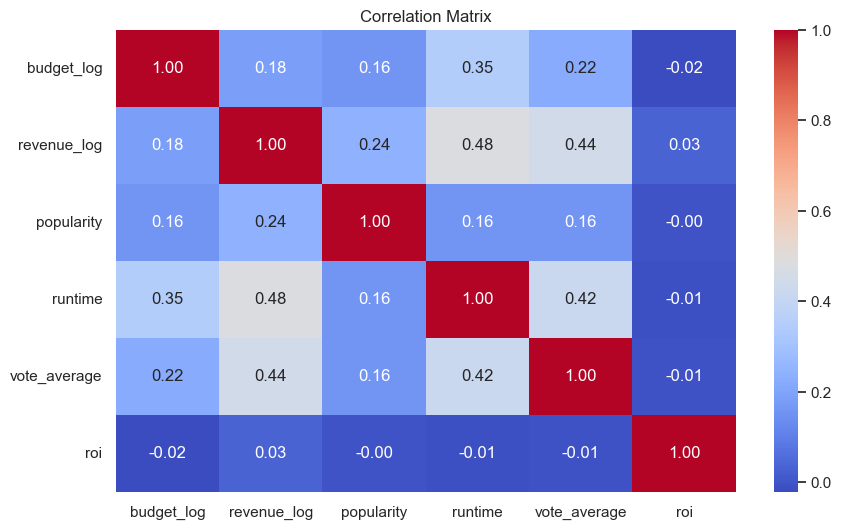

In [ ]:
# A5: Correlation heatmap to visualize relationships
corr_features = ['budget_log', 'revenue_log', 'popularity', 'runtime', 'vote_average', 'roi']

plt.figure(figsize=(10, 6))
sns.heatmap(df[corr_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

<Axes: xlabel='budget', ylabel='popularity'>

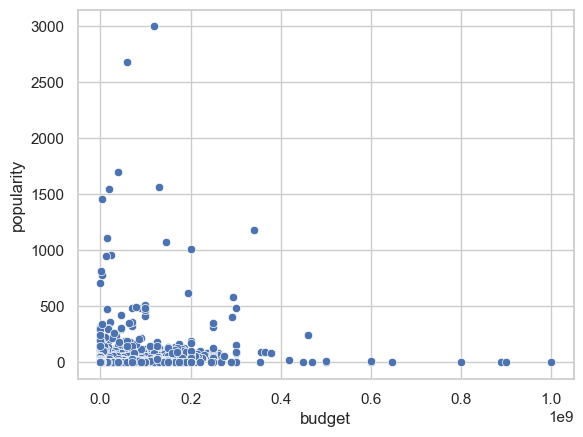

In [ ]:
sns.scatterplot(data=df, x="budget", y="popularity")


## Data Preprocessing 

For our project, we have considered using both dimensionality reduction and scaling. We are considering dropiing multiple columns in our model that are irrelevant to our project statement. When we implent these ideas into our project, they should drop unnecesary information which would allow XG Boost to significantlly run faster.

We created new engineered features to improve prediction performance:
    budget_log and revenue_log: log-transformed to reduce skew
    roi (Return on Investment):This helps capture how profitable a movie was relative to its cost.
We also converted vote_average into three categories:
    Low: score < 5; Medium: 5–7; High: score > 7

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np

# Define your features
features = ['budget_log', 'revenue_log', 'popularity', 'runtime', 'roi']

# Step 1: Create a copy of your feature data
X = df[features].copy()

# Step 2: Replace inf/-inf with NaN and drop all rows with any NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.dropna(inplace=True)

# Step 3: Align target variable y to match cleaned X
y = df.loc[X.index, 'score_class']

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Step 5: Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Step 6: Predict and evaluate
y_pred = clf.predict(X_test)

print("✅ Model trained and evaluated.")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


✅ Model trained and evaluated.
[[ 374 1100  427]
 [ 311 6468  509]
 [ 214  648 1752]]
              precision    recall  f1-score   support

        high       0.42      0.20      0.27      1901
         low       0.79      0.89      0.83      7288
      medium       0.65      0.67      0.66      2614

    accuracy                           0.73     11803
   macro avg       0.62      0.58      0.59     11803
weighted avg       0.70      0.73      0.70     11803



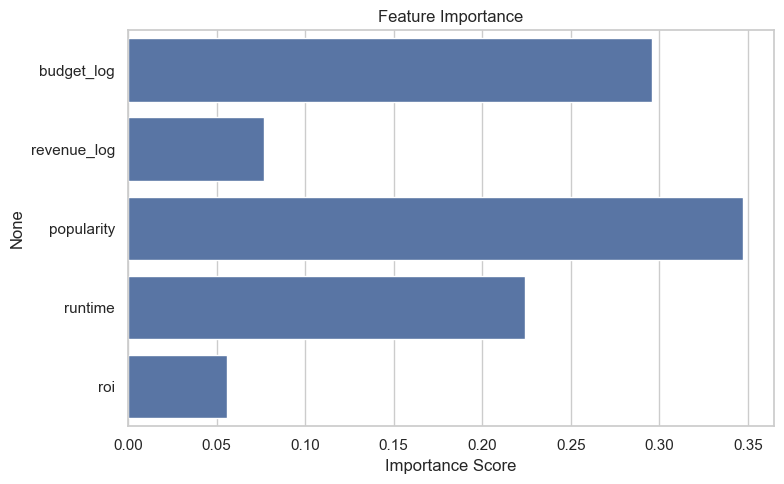

In [ ]:
# A7: Plotting which features were most important to the model
importances = clf.feature_importances_
feat_names = X.columns

plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=feat_names)
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Select only numeric columns
numeric_cols = df.select_dtypes(include='number').columns
df_numeric = df[numeric_cols].copy()

# Clean the data before scaling
df_numeric.replace([np.inf, -np.inf], np.nan, inplace=True)
df_numeric.dropna(inplace=True)  # or use fillna(df_numeric.median()) instead

# Scale
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_numeric), columns=df_numeric.columns, index=df_numeric.index)


# Random Forest Regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Features and target
features = ['budget_log', 'revenue_log', 'popularity', 'runtime', 'roi']
X = df[features].copy()
y = df['vote_average'].copy()

# Clean up
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.dropna(inplace=True)
y = y.loc[X.index]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Regression Model
reg_model = RandomForestRegressor(n_estimators=100, random_state=42)
reg_model.fit(X_train, y_train)

# Predict and Evaluate
y_pred = reg_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")


R² Score: 0.270
RMSE: 2.966


## XGboost 

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Encode the target if not done yet
le = LabelEncoder()
df['score_class_encoded'] = le.fit_transform(df['score_class'])

# Define features and copy safely
features = ['budget_log', 'revenue_log', 'popularity', 'runtime', 'roi']
X = df[features].copy()

# Clean X
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.dropna(inplace=True)  # or use: X.fillna(X.median(), inplace=True)

# Align target to cleaned X
y_class = df.loc[X.index, 'score_class_encoded']

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_class, test_size=0.2, stratify=y_class, random_state=42
)

# Train model
clf = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='mlogloss'  # No need for use_label_encoder anymore
)

clf.fit(X_train, y_train)

# Predict + Evaluate
y_pred = clf.predict(X_test)

print("✅ Model trained and evaluated.")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


✅ Model trained and evaluated.
Accuracy: 0.7635346945691773
[[ 270 1220  411]
 [  17 6896  375]
 [ 114  654 1846]]
              precision    recall  f1-score   support

           0       0.67      0.14      0.23      1901
           1       0.79      0.95      0.86      7288
           2       0.70      0.71      0.70      2614

    accuracy                           0.76     11803
   macro avg       0.72      0.60      0.60     11803
weighted avg       0.75      0.76      0.72     11803



## Machine Learning Approaches

For our baseline evaluation, we initially used Random Forest Regression since our data was in float format and better suited for regression tasks. However, this approach did not yield the results we were aiming for, with R-squared scores remaining in the mid-0.30s. To improve performance, we transformed the continuous values into categorical buckets—High, Medium, and Low—which allowed us to shift from regression to classification. This change enabled us to leverage classification algorithms such as Random Forest Classifier and XGBoost, along with preprocessing tools like SK-Learn’s Standard Scaler. As a result, our accuracy, precision, and recall improved significantly, reaching the mid to high 70s. This classification-based approach aligned better with the structure of our data and led to more representative and meaningful outcomes.

/var/folders/lb/1csx2bzn3gsc_zhvm70sb2hm0000gn/T/ipykernel_3029/4279922939.py:36: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_melted, x='class', y='value', hue='model', palette='Set2', ci=None, capsize=.1, dodge=True)


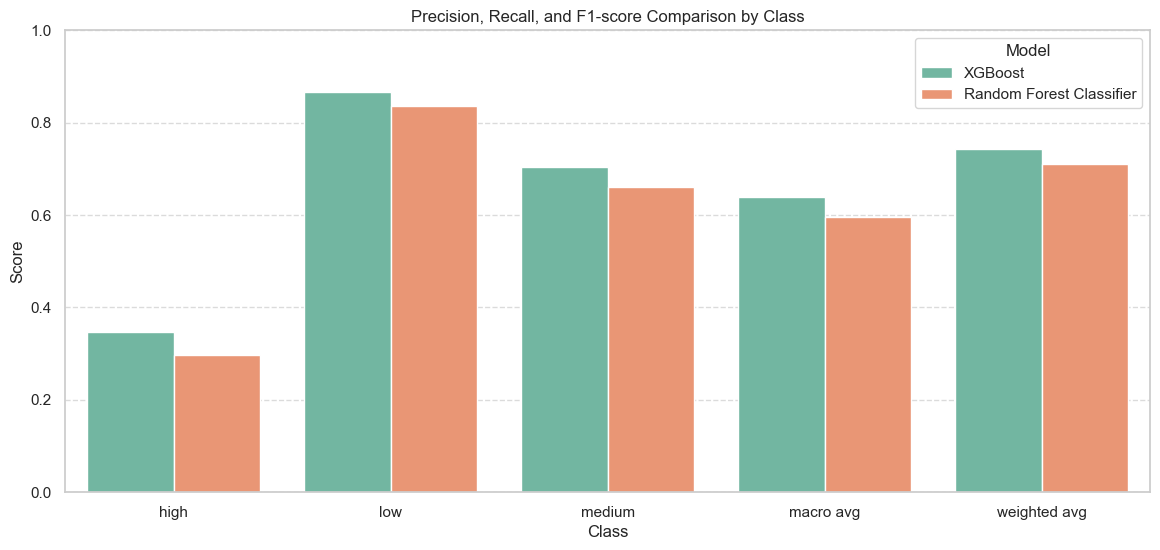

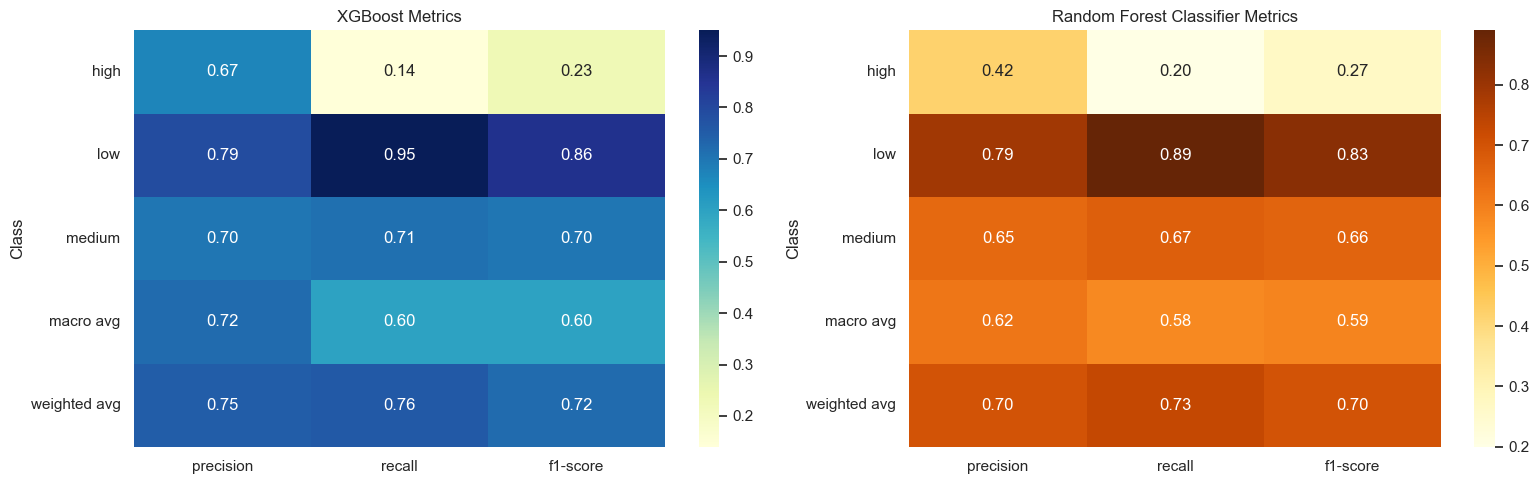

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Classes and metrics
classes = ['high', 'low', 'medium', 'macro avg', 'weighted avg']
metrics = ['precision', 'recall', 'f1-score']

# Data from XGBoost
xgb = {
    'precision': [0.67, 0.79, 0.70, 0.72, 0.75],
    'recall':    [0.14, 0.95, 0.71, 0.60, 0.76],
    'f1-score':  [0.23, 0.86, 0.70, 0.60, 0.72]
}

# Data from Random Forest
rf = {
    'precision': [0.42, 0.79, 0.65, 0.62, 0.70],
    'recall':    [0.20, 0.89, 0.67, 0.58, 0.73],
    'f1-score':  [0.27, 0.83, 0.66, 0.59, 0.70]
}

# Create DataFrames
df_xgb = pd.DataFrame(xgb, index=classes)
df_rf = pd.DataFrame(rf, index=classes)

# Combine and melt for seaborn
df_xgb['model'] = 'XGBoost'
df_rf['model'] = 'Random Forest Classifier'
df_combined = pd.concat([df_xgb, df_rf]).reset_index().rename(columns={'index': 'class'})
df_melted = pd.melt(df_combined, id_vars=['class', 'model'], value_vars=metrics, var_name='metric')

# Bar chart
plt.figure(figsize=(14, 6))
sns.barplot(data=df_melted, x='class', y='value', hue='model', palette='Set2', ci=None, capsize=.1, dodge=True)
plt.title("Precision, Recall, and F1-score Comparison by Class")
plt.xlabel("Class")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend(title="Model")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

# Matrix-style heatmap comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sns.heatmap(df_xgb.drop(columns='model'), annot=True, cmap='YlGnBu', fmt=".2f", ax=axes[0])
axes[0].set_title("XGBoost Metrics")
axes[0].set_ylabel("Class")

sns.heatmap(df_rf.drop(columns='model'), annot=True, cmap='YlOrBr', fmt=".2f", ax=axes[1])
axes[1].set_title("Random Forest Classifier Metrics")
axes[1].set_ylabel("Class")

plt.tight_layout()
plt.show()


## Experiments 

As of 4/18/2025, the experiments that we did were random forrest classifier, random forest regressor, and XG Boost, with XG Boost being the most accurate with a combined accuracy score of 0.79 when averaging the recall, precision, and F1 score.

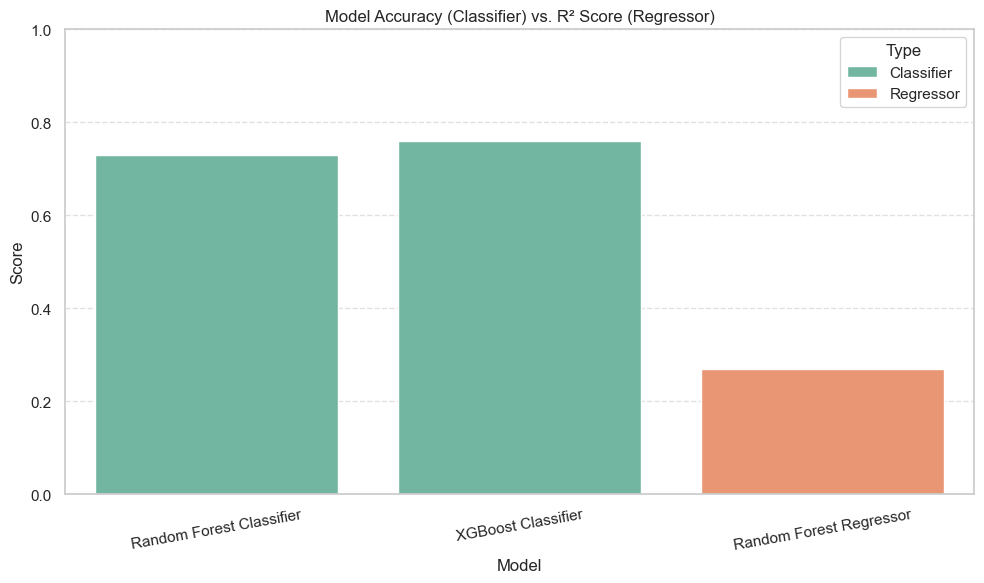

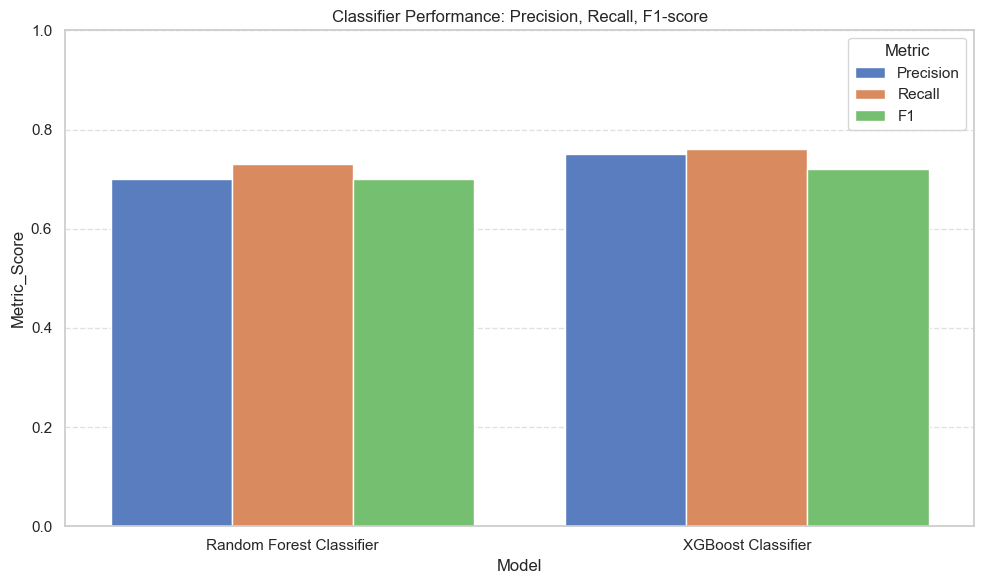

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set plot style
sns.set(style="whitegrid")

# ==== 1. Input Metrics ====

# Classifier Metrics (macro avg or weighted avg used for comparison)
rf_classifier = {'Model': 'Random Forest Classifier', 'Type': 'Classifier', 'Score': 0.73, 'Precision': 0.70, 'Recall': 0.73, 'F1': 0.70, 'RMSE': None}
xgb_classifier = {'Model': 'XGBoost Classifier', 'Type': 'Classifier', 'Score': 0.76, 'Precision': 0.75, 'Recall': 0.76, 'F1': 0.72, 'RMSE': None}

# Regressor Metrics
rf_regressor = {'Model': 'Random Forest Regressor', 'Type': 'Regressor', 'Score': 0.27, 'Precision': None, 'Recall': None, 'F1': None, 'RMSE': 2.97}

# Combine into DataFrame
model_metrics = pd.DataFrame([rf_classifier, xgb_classifier, rf_regressor])

# ==== 2. Plot Accuracy/R² ====

plt.figure(figsize=(10, 6))
sns.barplot(data=model_metrics, x='Model', y='Score', hue='Type', palette='Set2')
plt.title('Model Accuracy (Classifier) vs. R² Score (Regressor)')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=10)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# ==== 3. Classifier Precision, Recall, F1 ====

classifiers_only = model_metrics[model_metrics['Type'] == 'Classifier']

# Melt safely using a unique value_name
melted_metrics = pd.melt(classifiers_only,
                         id_vars='Model',
                         value_vars=['Precision', 'Recall', 'F1'],
                         var_name='Metric',
                         value_name='Metric_Score')

# Plot classifier metrics
plt.figure(figsize=(10, 6))
sns.barplot(data=melted_metrics, x='Model', y='Metric_Score', hue='Metric', palette='muted')
plt.title('Classifier Performance: Precision, Recall, F1-score')
plt.ylim(0, 1)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## Conclusion

In this project, we set out to determine whether a movie’s budget and related financial or popularity features could predict its user review score. We tested multiple machine learning approaches on a cleaned dataset derived from the TMDB movie database.

What didn’t work?

    Our initial approach used Random Forest Regressor to predict the continuous vote_average. While simple to implement, it yielded a relatively poor R² value (~0.35), indicating that the model was unable to explain much of the variance in user ratings. It also produced predictions clustered around the mean, failing to capture high- and low-rated films effectively.

Why didn’t it work?

    The review scores had limited variance (most between 5 and 8), and financial features like budget and revenue didn’t correlate strongly with vote_average. As a result, a regression approach lacked sufficient signal to be effective. Additionally, the skewed distributions of budget and revenue likely hindered model learning without transformation.

What did we try?

    We shifted to a classification approach by binning vote_average into three categories: low (<5), medium (5–7), and high (>7). This allowed us to reframe the problem into a multiclass classification task. We tested two models:

    Random Forest Classifier (baseline), XGBoost Classifier (improved model)

What features worked well, and what didn’t?

    Popularity and budget were the most predictive features. Popularity in particular helped identify low-rated films.

    Revenue, while correlated with budget, offered limited additional signal.

Methods that failed and how we measured that:

    The Random Forest Regressor failed due to low R² (~0.35), high RMSE, and flat predictions. It was unable to differentiate between extremes in vote_average.

    Classification improved performance: XGBoost achieved 76% accuracy and a weighted F1-score of ~0.72. However, recall for the “high” review score class remained low (0.14), indicating the model still struggled to predict high-scoring films accurately.

How was this a data-driven process?

    We dropped rows with zero budget or revenue after confirming they made up >90% of the dataset and lacked predictive value.

    Log transformations were applied after observing extreme skew in budget and revenue histograms.

    Classification was selected after analyzing the weak correlation between budget and review score.

    Class performance metrics (especially recall for minority classes) guided our model comparisons.

Overall, we found that while financial data like budget and popularity can help predict broad review score categories, they are not sufficient to capture critical success precisely. The results suggest that other features — such as genre, cast, or textual reviews — would be needed for deeper predictive power.